In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import load_dataset
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_length = 512
batch_size = 4
epochs = 3
lr = 3e-4

In [2]:
model = AutoModelForCausalLM.from_pretrained('HuggingFaceTB/SmolLM-135M-Instruct').to(device)
tokenizer = AutoTokenizer.from_pretrained('HuggingFaceTB/SmolLM-135M-Instruct',use_fast=False)
dataset = load_dataset('benchang1110/emoji-chat', split='train')

In [3]:
def apply_chat_template(batch):
    return {"formatted_chat": [tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False) for chat in batch["conversation"]]}
print(f'Before applying chat template: \n{dataset[0]["conversation"]}')
chat_dataset = dataset.map(apply_chat_template, batched=True)
print("\n===============================\n")
print(f'After applying chat template: \n{chat_dataset[0]["formatted_chat"]}')

Before applying chat template: 
[{'content': 'The distance between two stars is 6.52 × 10^5 light years. What is the distance between the two stars in parsecs? (1 parsec = 3.26 light years)\nAnswer Choices: (A) 2 × 10^5 (B) 4 × 10^6 (C) 5 × 10^7 (D) 7 × 10^7 (E) 9 × 10^8', 'role': 'user'}, {'content': 'The conversion between light years and parsecs involves dividing light years by a factor of 3.26.\n6.52 × 10^5 ly / (3.26 ly/parsec) = 2 x 10^5 parsec\n✨\nThe answer is A. 🚀', 'role': 'assistant'}]


After applying chat template: 
<|im_start|>user
The distance between two stars is 6.52 × 10^5 light years. What is the distance between the two stars in parsecs? (1 parsec = 3.26 light years)
Answer Choices: (A) 2 × 10^5 (B) 4 × 10^6 (C) 5 × 10^7 (D) 7 × 10^7 (E) 9 × 10^8<|im_end|>
<|im_start|>assistant
The conversion between light years and parsecs involves dividing light years by a factor of 3.26.
6.52 × 10^5 ly / (3.26 ly/parsec) = 2 x 10^5 parsec
✨
The answer is A. 🚀<|im_end|>



In [4]:
def tokenized_dataset(dataset):
    return dataset.map(tokenize_function,batched=True,remove_columns=['formatted_chat'])

def tokenize_function(dataset):
    return tokenizer(dataset['formatted_chat'],padding=False,max_length=max_length,truncation=True)

token_dataset = tokenized_dataset(chat_dataset)
print(f"The eos token id is {tokenizer.eos_token_id}")
print(f"The pad token id is {tokenizer.pad_token_id}")
print(f'The input_ids after tokenization: \n{token_dataset[0]["input_ids"]}')
print(f'The attention_mask after tokenization: \n{token_dataset[0]["attention_mask"]}')

The eos token id is 2
The pad token id is 2
The input_ids after tokenization: 
[1, 4093, 198, 504, 4052, 826, 827, 5703, 314, 216, 38, 30, 37, 34, 15493, 216, 33, 32, 78, 37, 1420, 929, 30, 1812, 314, 260, 4052, 826, 260, 827, 5703, 281, 1280, 5016, 99, 47, 365, 33, 1280, 5016, 446, 216, 35, 30, 34, 38, 1420, 929, 25, 198, 21350, 35413, 42, 365, 49, 25, 216, 34, 15493, 216, 33, 32, 78, 37, 365, 50, 25, 216, 36, 15493, 216, 33, 32, 78, 38, 365, 51, 25, 216, 37, 15493, 216, 33, 32, 78, 39, 365, 52, 25, 216, 39, 15493, 216, 33, 32, 78, 39, 365, 53, 25, 216, 41, 15493, 216, 33, 32, 78, 40, 2, 198, 1, 520, 9531, 198, 504, 9538, 826, 1420, 929, 284, 1280, 5016, 99, 3445, 15213, 1420, 929, 411, 253, 4186, 282, 216, 35, 30, 34, 38, 30, 198, 38, 30, 37, 34, 15493, 216, 33, 32, 78, 37, 12511, 2272, 365, 35, 30, 34, 38, 12511, 31, 1095, 5016, 25, 446, 216, 34, 1792, 216, 33, 32, 78, 37, 1280, 5016, 198, 38083, 118, 198, 504, 2988, 314, 330, 30, 15107, 244, 218, 2, 198]
The attention_mask after to

In [5]:
split_dataset = token_dataset.train_test_split(test_size=0.1)
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']
print(f'The length of the training dataset: {len(train_dataset)}')
print(f'The length of the testing dataset: {len(test_dataset)}')

The length of the training dataset: 1402
The length of the testing dataset: 156


In [6]:
from transformers import DataCollatorForLanguageModeling

print(f'The pad token id is:{tokenizer.pad_token_id}')
print(f'The eos token id is:{tokenizer.eos_token_id}')
sentences = ["The answer is A.<|im_end|>", "<|im_start|>The way longer sentence is coming here!<|im_end|>"]
tokenized_sentences = [tokenizer(sentence) for sentence in sentences]
# print(f'The tokenized sentences: \n{tokenized_sentences}\n')

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
batch = data_collator(tokenized_sentences)
print(f"The input_ids after collating: \n{batch['input_ids']}\n")
print(f"The attention_mask after collating: \n{batch['attention_mask']}\n")
print(f"The labels after collating: \n{batch['labels']}\n")

The pad token id is:2
The eos token id is:2
The input_ids after collating: 
tensor([[ 504, 2988,  314,  330,   30,    2,    2,    2,    2,    2],
        [   1,  504,  970, 2848, 6330,  314, 4167, 1535,   17,    2]])

The attention_mask after collating: 
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

The labels after collating: 
tensor([[ 504, 2988,  314,  330,   30, -100, -100, -100, -100, -100],
        [   1,  504,  970, 2848, 6330,  314, 4167, 1535,   17, -100]])



In [7]:
from transformers import DataCollatorForLanguageModeling
from collections.abc import Mapping
from transformers.data.data_collator import _torch_collate_batch

class CustomDataCollator(DataCollatorForLanguageModeling):
    def torch_call(self, examples):
        # Handle dict or lists with proper padding and conversion to tensor.
        if isinstance(examples[0], Mapping):
            batch = self.tokenizer.pad(examples, return_tensors="pt", pad_to_multiple_of=self.pad_to_multiple_of)
        else:
            batch = {
                "input_ids": _torch_collate_batch(examples, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)
            }

        # If special token mask has been preprocessed, pop it from the dict.
        special_tokens_mask = batch.pop("special_tokens_mask", None)
        if self.mlm:
            batch["input_ids"], batch["labels"] = self.torch_mask_tokens(
                batch["input_ids"], special_tokens_mask=special_tokens_mask
            )
        else:
            labels = batch["input_ids"].clone()
            if self.tokenizer.pad_token_id is not None:
                labels[batch["attention_mask"] == 0] = -100
            batch["labels"] = labels
        return batch


In [8]:
sentences = ["<|im_start|>The shorter sentence<|im_end|>", "<|im_start|> The way longer sentence is coming <|im_end|>"]
tokenized_sentences = [tokenizer(sentence) for sentence in sentences]
print(f'The tokenized sentences: \n{tokenized_sentences}\n')

data_collator = CustomDataCollator(tokenizer=tokenizer, mlm=False)
batch = data_collator(tokenized_sentences)
print(f"The input_ids after collating: \n{batch['input_ids']}\n")
print(f"The attention_mask after collating: \n{batch['attention_mask']}\n")
print(f"The labels after collating: \n{batch['labels']}\n")

The tokenized sentences: 
[{'input_ids': [1, 504, 9895, 6330, 2], 'attention_mask': [1, 1, 1, 1, 1]}, {'input_ids': [1, 378, 970, 2848, 6330, 314, 4167, 216, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}]

The input_ids after collating: 
tensor([[   1,  504, 9895, 6330,    2,    2,    2,    2,    2],
        [   1,  378,  970, 2848, 6330,  314, 4167,  216,    2]])

The attention_mask after collating: 
tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])

The labels after collating: 
tensor([[   1,  504, 9895, 6330,    2, -100, -100, -100, -100],
        [   1,  378,  970, 2848, 6330,  314, 4167,  216,    2]])



In [9]:
add_pad_token = False
if add_pad_token is True:
    tokenizer.add_special_tokens({'pad_token':'<pad>'})
    print(f'The pad token id is:{tokenizer.pad_token_id}')
    print(f'The eos token id is:{tokenizer.eos_token_id}')
    tokenized_sentences = [tokenizer(sentence) for sentence in sentences]
    print(f'The tokenized sentences: \n{tokenized_sentences}\n')
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    batch = data_collator(tokenized_sentences)
    print(f"The input_ids after collating: \n{batch['input_ids']}\n")
    print(f"The attention_mask after collating: \n{batch['attention_mask']}\n")
    print(f"The labels after collating: \n{batch['labels']}\n")
    # remember to retokenize the dataset after adding the special tokens or the collator will not work properly!!!
    token_dataset = tokenized_dataset(chat_dataset)
    split_dataset = token_dataset.train_test_split(test_size=0.1)
    train_dataset, test_dataset = split_dataset['train'], split_dataset['test']
    print(f'The length of the training dataset: {len(train_dataset)}')
    print(f'The length of the testing dataset: {len(test_dataset)}')
    model.resize_token_embeddings(len(tokenizer))
    

In [10]:
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir='checkpoint', #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=epochs, # number of training epochs
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    learning_rate=lr,
    weight_decay = 0,
    warmup_ratio = 0.1,
    max_grad_norm = 1.0, #gradient clipping
    lr_scheduler_type = 'cosine',
    fp16=True,
    gradient_accumulation_steps=1,
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps= 10,
    evaluation_strategy="steps",
    save_steps = 100,
    save_total_limit=3,
    gradient_checkpointing=True,
    eval_accumulation_steps=1,
    dataloader_num_workers=16,
    dataloader_pin_memory=False,
    remove_unused_columns=True,
    eval_steps = 100,
)

/home/nitro5_wsl/miniconda3/envs/test/lib/python3.9/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

class LoggerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_losses = {'loss': [], 'step': []}
        self.eval_losses = {'loss': [], 'step': []}
    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Event called after logging the last logs.
        """
        if 'loss' in logs:
            self.train_losses['loss'].append(logs['loss'])
            self.train_losses['step'].append(state.global_step)
        if 'eval_loss' in logs:
            self.eval_losses['loss'].append(logs['eval_loss'])
            self.eval_losses['step'].append(state.global_step)
        plt.cla()
        plt.plot(self.train_losses['step'],self.train_losses['loss'], label='train')
        plt.plot(self.eval_losses['step'],self.eval_losses['loss'], label='eval')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('loss_curve.png')

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/nitro5_wsl/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,1.462000,1.548942
200,1.509800,1.539081
300,1.625100,1.511674
400,1.071500,1.528288
500,1.228100,1.527990
600,0.945900,1.515440
700,1.215700,1.492582
800,0.733300,1.644121
900,0.700000,1.641002
1000,0.726400,1.650331


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/nitro5_wsl/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/nitro5_wsl/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not pass

('emoji_chat_model/tokenizer_config.json',
 'emoji_chat_model/special_tokens_map.json',
 'emoji_chat_model/vocab.json',
 'emoji_chat_model/merges.txt',
 'emoji_chat_model/added_tokens.json')

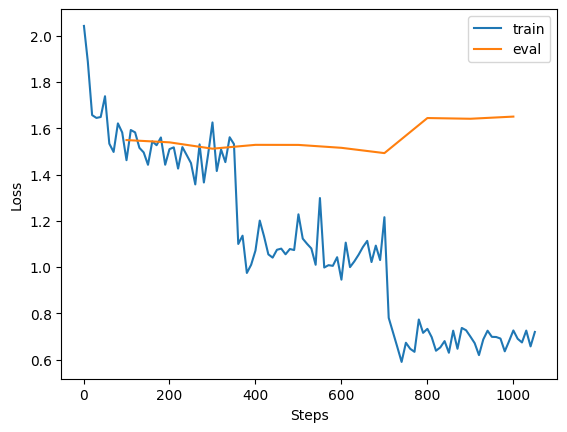

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[LoggerCallback()]
)
trainer.train()
trainer.save_model('emoji_chat_model')
tokenizer.save_pretrained('emoji_chat_model')

In [13]:
# test the model
from transformers import TextStreamer, AutoTokenizer, AutoModelForCausalLM
import torch
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_trained = True
if use_trained:
    model = AutoModelForCausalLM.from_pretrained('emoji_chat_model').to(device)
else:
    model = AutoModelForCausalLM.from_pretrained('HuggingFaceTB/SmolLM-135M-Instruct').to(device)

tokenizer = AutoTokenizer.from_pretrained('emoji_chat_model')
streamer = TextStreamer(tokenizer)

In [14]:
while True:
    prompt = input("Please enter your message: ")
    if prompt == 'exit':
        break
    messages = [
            {'content': prompt, 'role': 'user'},
        ]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True,return_tensors='pt',return_attention_mask=True).to(device)
    _ = model.generate(inputs, max_length=512, streamer=streamer, num_return_sequences=1,temperature=0.6, top_p=0.92,repetition_penalty=1.2, do_sample=True, use_cache=True)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>user
hello, what is your name?<|im_end|>
<|im_start|>assistant
😊 In this math puzzle, we need to find out how much our mysterious friend's name grows with each new person added! 🤔
Let's reason about the multi-choice question. We know that the sum of the differences between consecutive Sophie Germano numbers (123456789) and our current number (XYZ) is 10:
Sum = Difference
=> 10 - 12 + 10 - 13 + 10 - 14 + 10 - 15 + 10 - 16 = 10*12+10*(13)+10-(14+(16)) = XY^2 + YX^(12)- XY^(10) 💡
Now, let's calculate the value of XY^n for any positive integer n ⏪️. This will give us the final answer:
Final Answer = (N * (n/10)^(-1) + (A * (n/10)^(1-p)/10) 📝
In this case, N = 123456789, A = Y, and p = 10. So, the Final Answer would be: 🎉
Final Answer = ((123456789)*(123456789))/(10!) 😁
So, the Final Answer is: **((123456789)*(123456789))/(10!)** 👍<|im_end|>
